In [149]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from PIL import Image

In [2]:
from game_assets.utils import simplify_image, save_img
from conv_rgb.model import ConvRGB

In [3]:
from pysimulacra.data import SimulacraData

ds = SimulacraData('../raw_data/sac_public_2022_06_29.sqlite')

# data = ds.fetch_all_data()

In [5]:
# 'raw_data/sac-000000'

In [154]:
# 'simulacra-aesthetic-captions'

In [155]:
# img_df = ds.get_image_paths_and_prompts()

In [6]:
img_df = ds.get_image_paths_and_prompts_and_ratings()
img_df

,img_id,img_prompt,img_path,img_rating
0,1,An artwork of a broken wine bottle in the medi...,0_An_artwork_of_a_broken_wine_bottle_in_the_me...,7
1,1,An artwork of a broken wine bottle in the medi...,0_An_artwork_of_a_broken_wine_bottle_in_the_me...,1
2,6,An artwork of a broken wine bottle in the medi...,0_An_artwork_of_a_broken_wine_bottle_in_the_me...,4
3,5,An artwork of a broken wine bottle in the medi...,0_An_artwork_of_a_broken_wine_bottle_in_the_me...,6
4,4,An artwork of a broken wine bottle in the medi...,0_An_artwork_of_a_broken_wine_bottle_in_the_me...,6
...,...,...,...,...
176934,248438,beautiful portrait of a smiling flame witch ho...,43043_beautiful_portrait_of_a_smiling_flame_wi...,5
176935,248439,beautiful portrait of a smiling flame witch ho...,43043_beautiful_portrait_of_a_smiling_flame_wi...,7
176936,248440,beautiful portrait of a smiling flame witch ho...,43043_beautiful_portrait_of_a_smiling_flame_wi...,6
176937,248441,avatar of a dragon knight anato finnstark yosi...,43044_avatar_of_a_dragon_knight_anato_finnstar...,5


In [7]:
def square_image(pil_img):
    
    width, height = pil_img.size # Get dimensions
    
    if width < height:
        new_width, new_height = width, width
    else:
        new_width, new_height = height, height
        
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    
    bottom = (height + new_height)/2

    # Crop the center of the image
    im = pil_img.crop((left, top, right, bottom))
    
    return im

In [158]:
timg = Image.open('../raw_data/sac-000000/11175_3.png')

In [76]:
from PIL import ImageDraw, ImageFont
import textwrap

def simplify_image(pil_img, num_colors = 8, size = (256, 256)):

    img = pil_img.quantize(colors=num_colors, method=2)
    
    sq_img = square_image(img).resize(size, Image.LANCZOS)
    
    return sq_img

def add_border(old_img, width = 6, caption = None, caption_size = 12):
    
    img_arr = np.array(old_img)

    old_size = old_img.size
    
    new_size = [size + width for size in old_size]
    
    if caption:
        caption_wrapped = textwrap.wrap(caption, width=18)
        max_lines = 7
        if len(caption_wrapped) > max_lines:
            num_lines = max_lines
            caption_wrapped = caption_wrapped[:num_lines]
            last_words = caption_wrapped[-1].split(' ')
            last_words[-1] = '...'
            caption_wrapped[-1] = ' '.join(last_words)
        else:
            num_lines = len(caption_wrapped)
            caption_wrapped = caption_wrapped[:num_lines]
            
            
        new_size[1] += (caption_size) * num_lines
        
        
    new_img = Image.new("RGB", new_size, 'white')
    #box = tuple((n - o) // 2 for n, o in zip(new_size, old_size)) # centered
    box = tuple((new_size[0] - o) // 2 for o in old_size)
    new_img.paste(old_img, box)
    
    if caption:
        draw = ImageDraw.Draw(new_img)

        font = ImageFont.truetype('../dejavu-sans-mono/DejaVuSansMono.ttf', caption_size)
        
        for idx, line_text in enumerate(caption_wrapped):
            draw.text((width/2, old_size[0] + (width/2) + (idx * caption_size)), line_text.upper(), (0,0,0), font=font)

    return new_img

In [77]:
#240 characters makes 12 lines

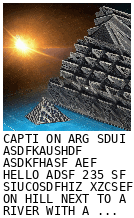

In [78]:
timg = Image.open('../raw_data/sac-000000/11175_3.png')
timg = simplify_image(timg, num_colors = 256, size = (128, 128))
add_border(timg, caption = "capti on arg sdui asdfkaushdf asdkfhasf aef hello adsf 235 sf siucosdfhiz xzcsef on hill next to a river with a happy forest")

In [79]:
def shorten_path(img_path):
    name_parts = img_path.split('_')
    new_name = f'{name_parts[0]}_{name_parts[-1]}'
    return new_name

In [80]:
import regex as re
import string

def clean_png_path(file_name):
    
    file_name = file_name.replace(',', ' ')
    
    #suffix = file_name[-4:]
    
    clean_file_name = re.sub(r'[^A-Za-z0-9 ]+', '', file_name)
    
#     if clean_file_name == "":
#         clean_file_name
    
    return '_'.join(clean_file_name.split()) # + suffix


In [81]:
img_df['short_img_path'] = img_df.img_path.apply(shorten_path)

img_df['clean_prompt'] = img_df.img_prompt.apply(clean_png_path)

240

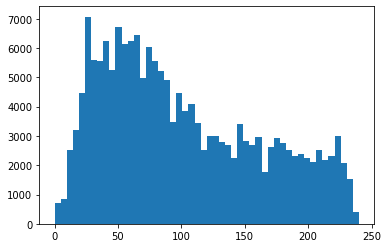

In [82]:
import matplotlib.pyplot as plt
plt.hist([len(x) for x in img_df['clean_prompt']], bins = 50);
max([len(x) for x in img_df['clean_prompt']])

In [47]:
# https://github.com/google-research-datasets/conceptual-captions/blob/master/LICENSE
# https://ai.google.com/research/ConceptualCaptions/download

# data = pd.read_csv('../raw_data/Validation_GCC-1.1.0-Validation.tsv', sep = '\t', header = None)
# data.columns = ['caption', 'url']

In [83]:
import torch
import clip

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-L/14", device=device) # "ViT-B/32"

def clip_encode_image(pil_img):
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    image = preprocess(pil_img).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)

    return image_features


In [84]:
colour_model = ConvRGB(input_shape = (240, 240), n_cut = 8)

2022-08-24 16:25:47.003658: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [85]:
import matplotlib.pyplot as plt

def colours_as_pct(input_images):
#     print(np.min(input_images))
    images = np.add(np.ones(input_images.shape), input_images)
#   images = images + 1 # avoid dividing by zero
#     if np.min(images) == '0':
#     print('min:',  np.min(images))
#     print(type(images))
#     print(images)
#     plt.imshow(images[0] / 255)
#     plt.show()
        
#     images = np.true_divide(images, images.sum(axis=-1, keepdims=True))
    
    images = images / images.sum(axis=-1, keepdims=True)
    return images

In [86]:
def colour_encode_image(pil_img):
    
    img = pil_img.resize((240, 240))
    
    X = np.expand_dims(np.array(img), axis = 0)
    
    X = colours_as_pct(X)
    
    colour_features = colour_model(X)
    
    return colour_features

In [87]:
# img_array_list = [np.array(Image.open(f'../raw_data/sac_images2/{image_path}')) for image_path in image_path_list]

In [88]:
def get_common_colors(img_array_list, top_k = 256):

    all_na = np.array(img_array_list)

    all_colours, all_counts = np.unique(all_na.reshape(-1,3), axis=0, return_counts=1) 
    
    threshold = sorted(counts)[-top_k]
    
    col_palette = (colours[counts >= threshold] * 255).astype(np.uint8).reshape((16, 16, 3))
    
    return col_palette


In [89]:
from itertools import product

def gen_color_palette(init_size):
    
    values = np.linspace(0, 255, init_size).astype(np.uint8)

    rgb_pal = np.array(list(product(values, repeat=3)))
    
    return rgb_pal

In [213]:
# plot a colourful triangle
# fig, axes = plt.subplots(10, 1, figsize = (2, 2))

# for i, ax in enumerate(axes.flat):
#     rgb_pal = gen_color_palette(i + 2)
#     ax.imshow(rgb_pal.reshape(i + 2, -1, 3))
#     ax.set_xticks([])
#     ax.set_yticks([])
    
# plt.savefig('../results/color_stack.png', facecolor = 'white')

In [ ]:
# 8-bit colour scheme is not always the same
# https://stackoverflow.com/questions/17728757/do-all-8-bit-colors-exist-in-24-bit-color-space-if-so-how-to-map

In [90]:
def qcolour_encode_image(pil_img, return_img = False):
    
    # could maybe increase the number of colour features ?

    colour_palette  = gen_color_palette(4)

    colour_palette_long = colour_palette.reshape(-1)

    pal_img = Image.new('P', (16, 16))
    pal_img.putpalette(list(colour_palette_long) * 4)

    q_img = pil_img.resize((16, 16)).quantize(palette=pal_img, dither=0, method=2)
    
    new_rgb_img = Image.new('RGB', (16, 16), 0xFF)
    new_rgb_img.paste(q_img)
    
    rgb_img = np.array(new_rgb_img) 
    
    # Get used colours and counts of each
    colours, counts = np.unique(rgb_img.reshape((-1,3)), axis=0, return_counts=1)
    
    # create dict of all possible colour features
    colour_counter = {k.tobytes(): 0 for k in colour_palette}
    
    for i in range(len(colours)):

        idx = colours[i].tobytes()

        count = counts[i]

        colour_counter[idx] = count
        
    features = np.array(list(colour_counter.values()))

    if return_img:
        return features, rgb_img
    else:
        return features


In [91]:
def plot_quantrgb(pil_img):
    
    f, axes = plt.subplots(1, 2, figsize = (12, 6))

    axes[0].imshow(pil_img)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    

    features, new_img = qcolour_encode_image(pil_img, return_img = True)
    axes[1].imshow(new_img)
    axes[1].set_xticks([])
    axes[1].set_yticks([])

In [1868]:
os.listdir('../raw_data/sac-000000/')

['25308_2.png',
 '13941_1.png',
 '26058_1.png',
 '38376_1.png',
 '1280_4.png',
 '16742_2.png',
 '7322_7.png',
 '10188_1.png',
 '13474_3.png',
 '8254_4.png',
 '15654_6.png',
 '8440_5.png',
 '16996_5.png',
 '7278_5.png',
 '31379_2.png',
 '5478_7.png',
 '9110_4.png',
 '5732_8.png',
 '31472_1.png',
 '42288_1.png',
 '20593_2.png',
 '1063_6.png',
 '17664_4.png',
 '41840_4.png',
 '18791_1.png',
 '5147_8.png',
 '33932_1.png',
 '16508_8.png',
 '3151_3.png',
 '30198_2.png',
 '36326_4.png',
 '18636_3.png',
 '16371_5.png',
 '23585_3.png',
 '38647_1.png',
 '32540_4.png',
 '27630_4.png',
 '37416_1.png',
 '19900_6.png',
 '9093_7.png',
 '28033_2.png',
 '26668_1.png',
 '6980_7.png',
 '12380_2.png',
 '10434_8.png',
 '22808_1.png',
 '11427_2.png',
 '36358_2.png',
 '38687_1.png',
 '13963_6.png',
 '8661_5.png',
 '5954_4.png',
 '409_4.png',
 '23870_1.png',
 '6509_4.png',
 '37792_1.png',
 '6650_1.png',
 '5275_7.png',
 '27165_4.png',
 '32215_4.png',
 '35419_1.png',
 '8434_8.png',
 '18002_7.png',
 '5662_1.png'

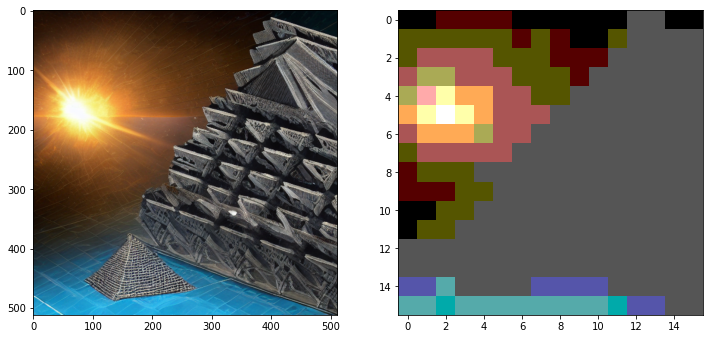

In [1865]:
timg = Image.open('../raw_data/sac-000000/11175_3.png')

plot_quantrgb(timg)

plt.savefig('../results/quan_rbg.png', facecolor = 'white')

In [1859]:
qcolour_encode_image(timg)

array([ 15,   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   0,   0,
         0,   0,   0,  14,   0,   0,   0,  27, 142,   8,   0,   0,   0,
        11,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  21,   0,
         0,   0,   4,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   7,   1,   0,   0,   0,   3,   1])

In [93]:
import os
all_imgs = os.listdir('../raw_data/sac-000000/')

exist_df = pd.DataFrame({'short_img_path': pd.Series(all_imgs)})

df = exist_df.merge(img_df, how = 'inner').drop_duplicates()

df = df[df['clean_prompt'] != '']

df_loop = df.sort_values('img_rating', ascending = False)[:1000]

In [217]:
# !mkdir ../raw_data/sac_images2

In [99]:
prev_images

{'85e40eb0b2d64ddfdd8cfcd8bc0faa7a': True}

In [104]:
!mkdir ../raw_data/sac_images_captions

In [105]:
import hashlib

clip_features_list = []
colour_features_list = []
image_path_list = []

prev_images = {}


for i, row in tqdm(df_loop.iterrows()):
    
    img_path, caption = row['short_img_path'], row['clean_prompt']
    
    if img_path.endswith('png'):

        img = Image.open(f'../raw_data/sac-000000/{img_path}')

        if img:
            
            img_hash = hashlib.md5(img.tobytes()).hexdigest()

            if img_hash not in prev_images:
                prev_images[img_hash] = True
            
                # calculate aesthetics here too
                # https://github.com/christophschuhmann/improved-aesthetic-predictor

                clip_features_list.append(clip_encode_image(img)[0])

                #img = colours_as_pct(img)
                #colour_features_list.append(colour_encode_image(img)[0])

                colour_features_list.append(qcolour_encode_image(img))

                simple_img = simplify_image(img, num_colors = 256, size = (128, 128))

                simple_img = add_border(simple_img, width = 8, caption = caption.replace('_', ' ').replace('.png', ''))

                save_img(simple_img, caption, destination_folder = '../raw_data/sac_images_captions')

                image_path_list.append(f"{caption}.png")
        
    

1000it [38:11,  2.29s/it]


In [106]:
image_embeddings = np.stack(clip_features_list)
colour_embeddings = np.stack(colour_features_list)


In [114]:
image_embeddings.shape

(885, 768)

In [115]:
colour_embeddings.shape

(885, 64)

In [110]:
colour_embeddings

array([[14,  0,  0, ...,  0,  0,  0],
       [44,  0,  0, ...,  0,  4,  1],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [19, 16,  0, ...,  0,  0,  0],
       [ 2,  6,  0, ...,  0,  0,  0],
       [14,  0,  0, ...,  1,  0,  0]])

(array([10.,  3.,  2.,  2.,  3.,  2.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,
         1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.05223865, 0.13977349, 0.22730833, 0.31484317, 0.40237801,
        0.48991284, 0.57744768, 0.66498252, 0.75251736, 0.8400522 ,
        0.92758704, 1.01512187, 1.10265671, 1.19019155, 1.27772639,
        1.36526123, 1.45279606, 1.5403309 , 1.62786574, 1.71540058,
        1.80293542, 1.89047025, 1.97800509, 2.06553993, 2.15307477,
        2.24060961, 2.32814444, 2.41567928, 2.50321412, 2.59074896,
        2.6782838 , 2.76581863, 2.85335347, 2.94088831, 3.02842315,
        3.11595799, 3.20349283, 3.29102766, 3.3785625 , 3.46609734,
        3.55363218, 3.64116702, 3.72870185, 3.81623669, 3.90377153,
        3.99130637, 4.07884121, 4.16637604, 4.25391088, 4.34144572,
        4.42898056]),
 <BarContainer

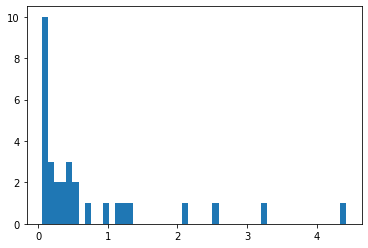

In [111]:
log_col_emb = np.ma.log(colour_embeddings).filled(0)

keep_mask = log_col_emb.mean(axis = 0) > sorted(log_col_emb.mean(axis = 0))[32]

# keep_mask = log_col_emb.sum(axis = 0) > sorted(log_col_emb.sum(axis = 0))[40]

common_colors = log_col_emb[:, keep_mask]

plt.hist(log_col_emb.mean(axis = 0)[keep_mask], bins = 50)

In [112]:
from sklearn.preprocessing import StandardScaler

s_image_embeddings = StandardScaler().fit_transform(image_embeddings)

s_colour_embeddings = StandardScaler().fit_transform(common_colors)

In [113]:
len(image_path_list)

885

In [117]:
both_embeddings = np.hstack([s_image_embeddings, s_colour_embeddings])

In [118]:
import pymde

image_mde = pymde.preserve_neighbors(s_image_embeddings, embedding_dim=2)
mde_image_2d = image_mde.embed()

image_mde = pymde.preserve_neighbors(both_embeddings, embedding_dim=2)
mde_both_2d = image_mde.embed()

colour_mde = pymde.preserve_neighbors(s_colour_embeddings, embedding_dim=2)
mde_colour_2d = colour_mde.embed()

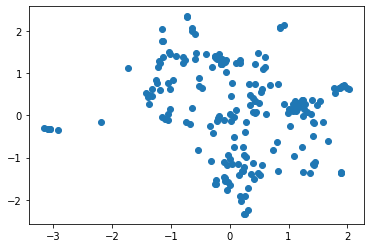

In [119]:
import matplotlib.pyplot as plt
plt.scatter(mde_both_2d[-200:, 0], mde_both_2d[-200:, 1])

In [1763]:
from umap import UMAP

umap_image_2d = UMAP().fit_transform(s_image_embeddings)
umap_colour_2d = UMAP().fit_transform(s_colour_embeddings)

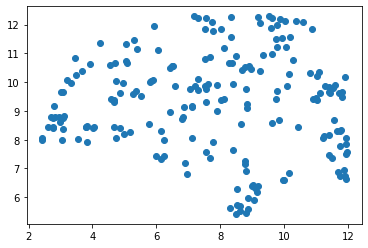

In [468]:

plt.scatter(umap_colour_2d[-200:, 0], umap_colour_2d[-200:, 1])

In [120]:
from sklearn.decomposition import PCA

In [121]:
# create and fit a 2d PCA


pca = PCA(2)
pca.fit(s_image_embeddings)

pca.explained_variance_

# actually project only PC's
pca_image_2d = pca.transform(s_image_embeddings)

In [122]:
pca = PCA(2)
pca_colour_2d = pca.fit_transform(s_colour_embeddings)
pca.explained_variance_

array([3.49367928, 3.1985148 ])

In [123]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from tensorflow.image import resize
from tqdm import tqdm
import numpy as np
from PIL import Image

def show_xy_images(x_coords, y_coords, img_arr_list, image_zoom=1):
    fig, ax = plt.subplots(1,1, figsize=(25, 25))
    artists = []
    for x_coord, y_coord, img in tqdm(zip(x_coords, y_coords, img_arr_list)):
        c_img = resize(img, [50,50])
        img = OffsetImage(c_img, zoom=image_zoom)
        ab = AnnotationBbox(img, (x_coord, y_coord),
                            xycoords='data',
                            frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.stack([x_coords, y_coords], axis=1))
    ax.autoscale()

200it [00:01, 194.41it/s]


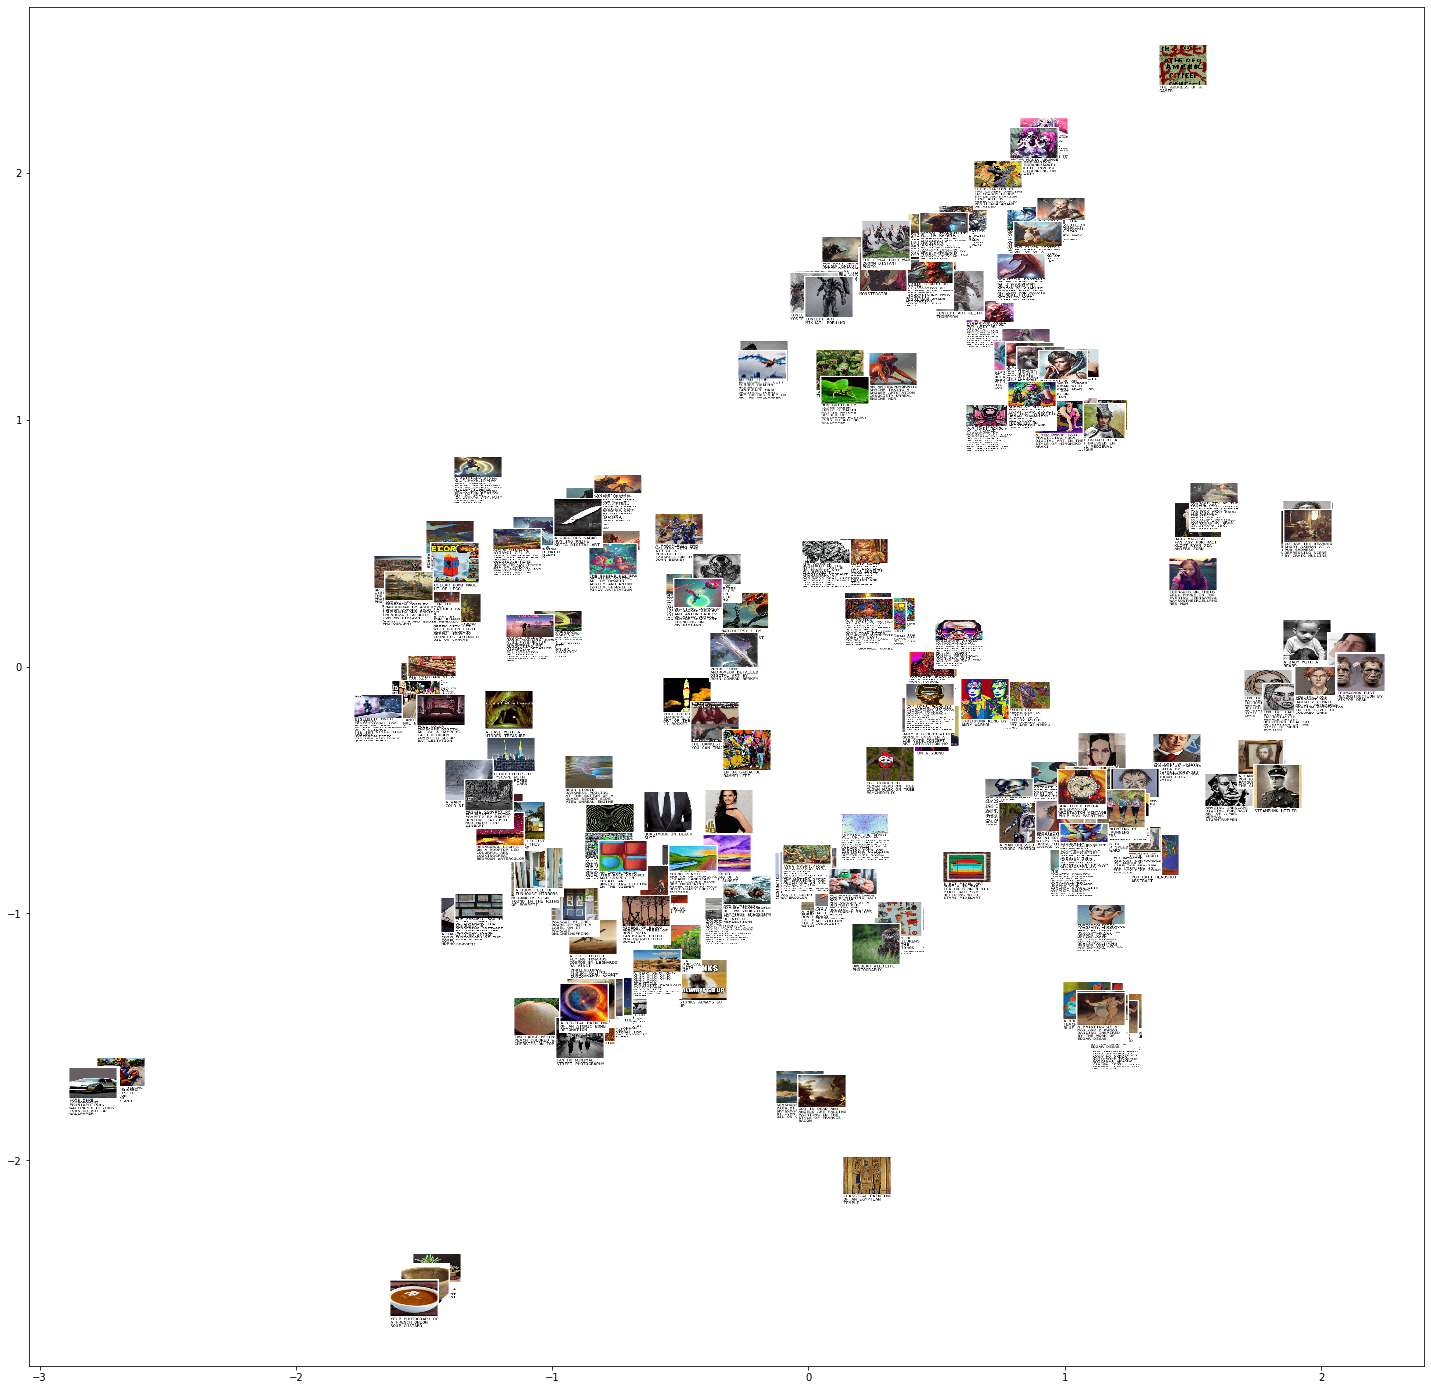

In [124]:
show_xy_images(x_coords = mde_image_2d[-200:, 0], 
               y_coords = mde_image_2d[-200:, 1], 
               img_arr_list = img_array_list[-200:])

# plt.savefig('../results/clip_world.png', facecolor = 'white')


/var/folders/_n/rrz6mzy13l71h2mg878ykrv80000gn/T/ipykernel_94003/25377024.py:1: RuntimeWarning: divide by zero encountered in log
  show_xy_images(x_coords = np.log(pca_colour_2d[-200:, 0] - min(pca_colour_2d[-200:, 0])),
200it [00:01, 139.13it/s]


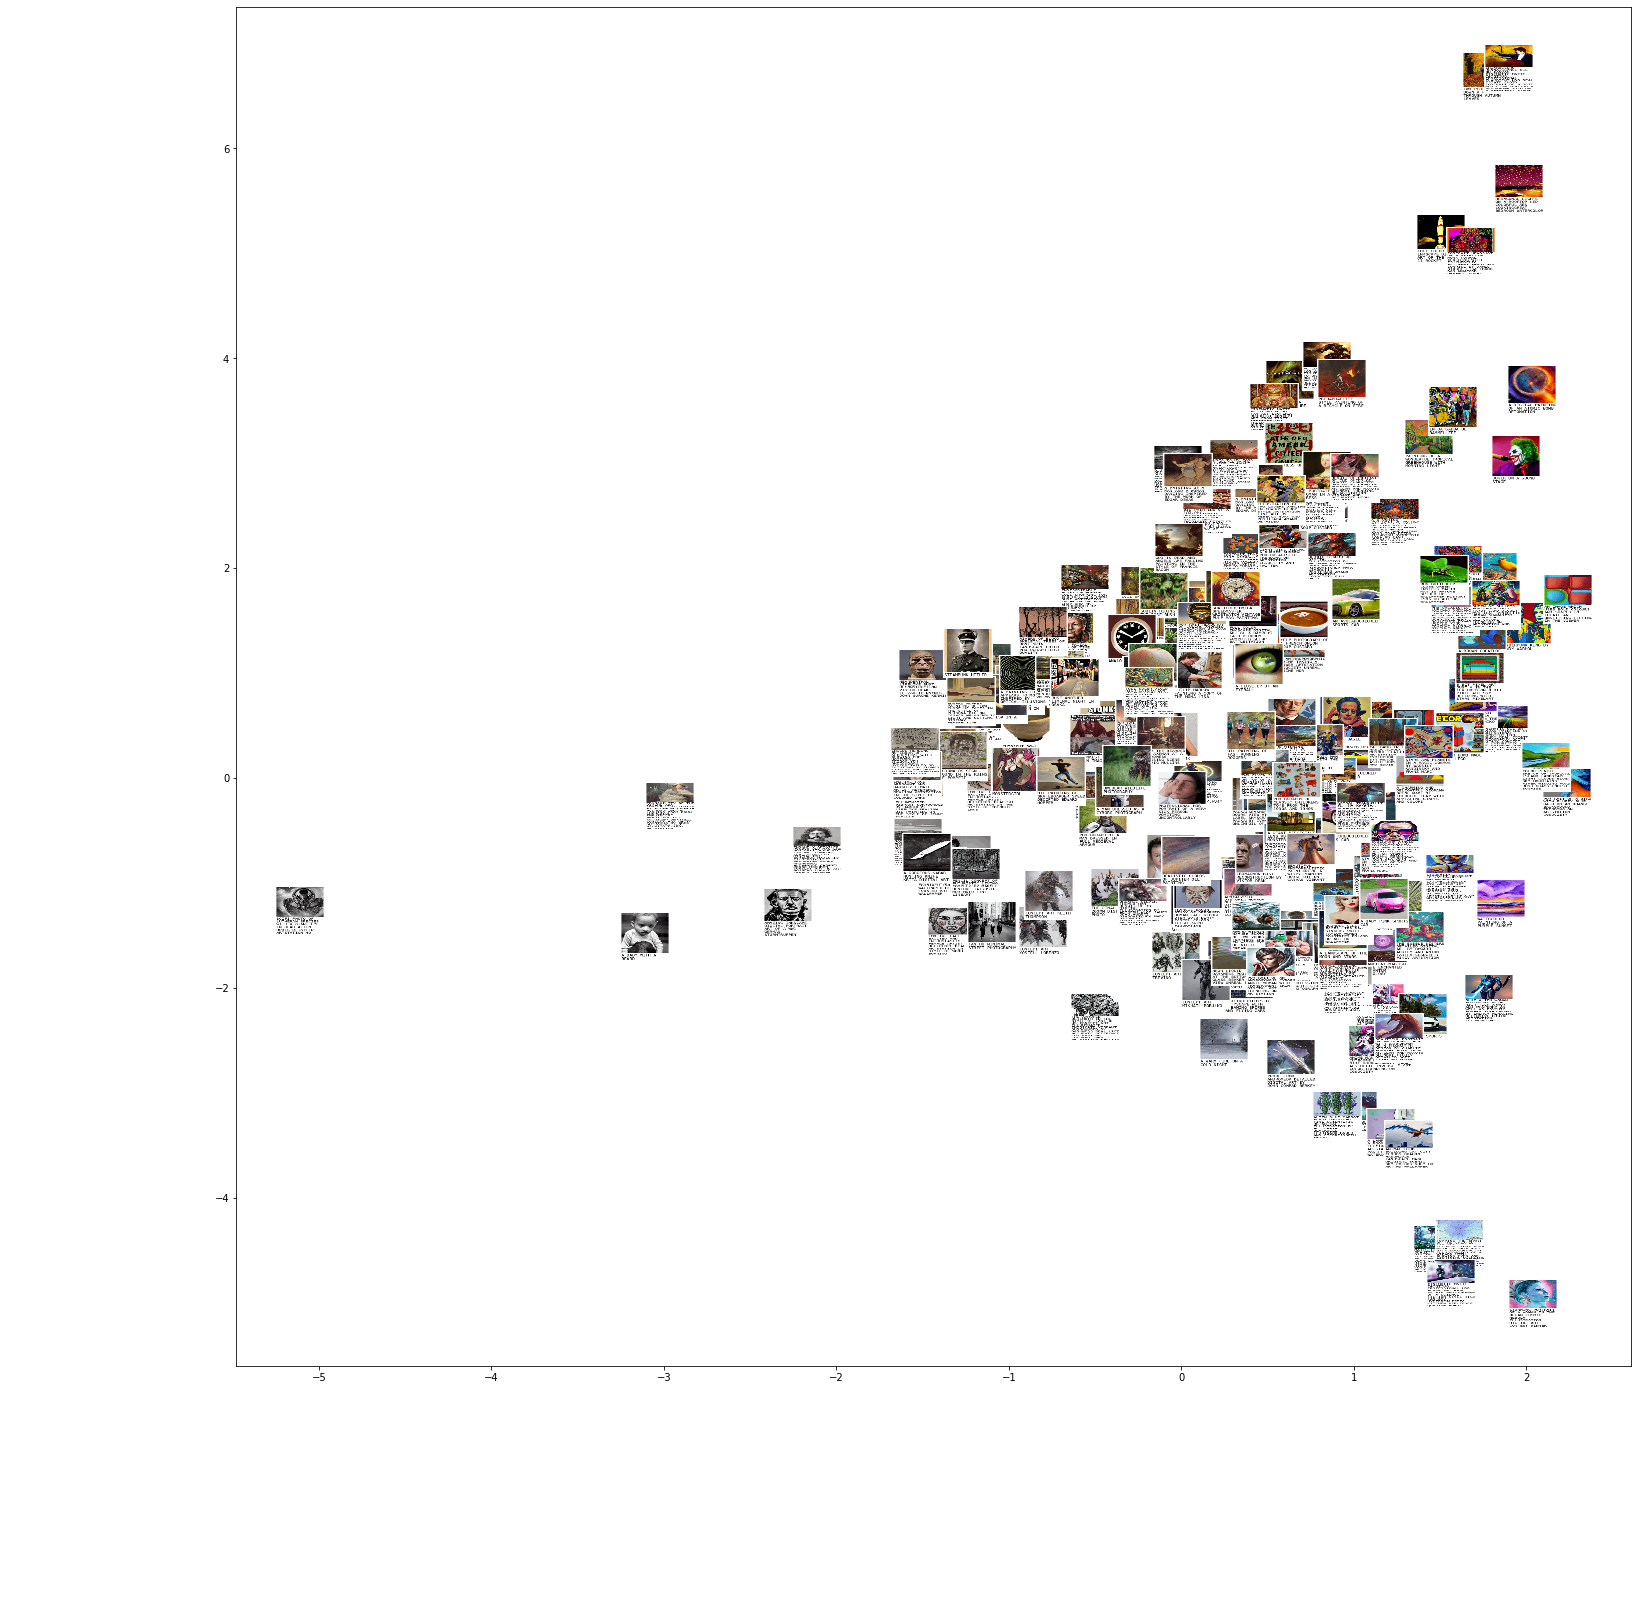

In [131]:
show_xy_images(x_coords = np.log(pca_colour_2d[-200:, 0] - min(pca_colour_2d[-200:, 0])), 
               y_coords = pca_colour_2d[-200:, 1], 
               img_arr_list = img_array_list[-200:])

plt.savefig('../results/colour_world.png', facecolor = 'white')

# show_xy_images(x_coords = pca_colour_2d[-200:, 0], 
#                y_coords = pca_colour_2d[-200:, 1], 
#                img_arr_list = img_array_list[-200:])

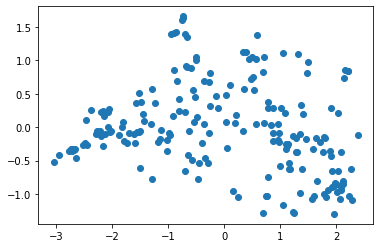

In [194]:
import matplotlib.pyplot as plt
plt.scatter(colour_2d[-200:, 0], colour_2d[-200:, 1])

In [127]:
!mkdir ../raw_data/sac_images_captions_subset

In [1854]:
# check images are the correct size
# base_folder = '../raw_data/sac_images_subset/'
# [name for name in os.listdir(base_folder) if Image.open(f'{base_folder}/{name}').size[0] != 136]

[]

In [128]:
import shutil

for path in image_path_list[-200:]:
    shutil.copy2(f'../raw_data/sac_images_captions/{path}', f'../raw_data/sac_images_captions_subset/{path}')

In [129]:
def embedding_to_coords(embedding, scale = 1000, log = False):
    
    from_one = embedding + abs(embedding.min())
    
    if log:
        from_one = np.ma.log(from_one).filled(0)
        from_one = from_one + abs(from_one.min())
        
    return [int(coord) for coord in (from_one / max(from_one) * scale)]

In [130]:
# take 200 images with the highest rating
import json

X_image_coords = embedding_to_coords(mde_image_2d[-200:, 0], scale = 1000)
Y_image_coords = embedding_to_coords(mde_image_2d[-200:, 1], scale = 1000)
X_colour_coords = embedding_to_coords(pca_colour_2d[-200:, 0], scale = 1000, log = True)
Y_colour_coords = embedding_to_coords(pca_colour_2d[-200:, 1], scale = 1000)

map_json = {
    "X_image_coords": X_image_coords,
    "Y_image_coords": Y_image_coords,
    "X_colour_coords": X_colour_coords,
    "Y_colour_coords": Y_colour_coords,
    "image_paths": image_path_list[-200:]
}

with open('../raw_data/sac_captions_latent_space_map.json', 'w') as f:
    json.dump(map_json, f)


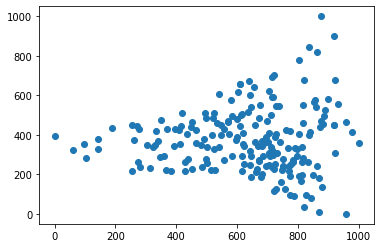

In [1849]:
plt.scatter(map_json['X_colour_coords'], map_json['Y_colour_coords'])

In [ ]:
# copy raw_data/sac_latent_space_map.json into the game assests folder

## Background

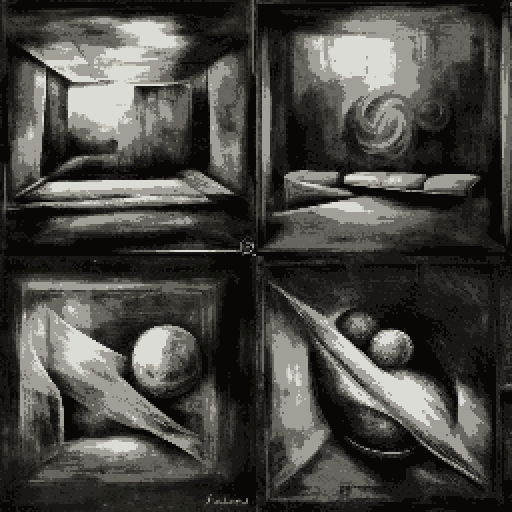

In [281]:
pil_img = Image.open('../raw_data/mj_background.png')
img = pil_img.quantize(colors=32, method=2).resize((256, 256), Image.LANCZOS).resize((512, 512), Image.LANCZOS)
img

In [282]:
img.save('../raw_data/latent_space_background_32bit.png')

## grid pic for promo


In [199]:
img_array_list = [np.array(Image.open(f'../raw_data/sd_latentmuseum_grid/{image_path}').resize((100, 100)))/255 for image_path in os.listdir('../raw_data/sd_latentmuseum_grid')]

In [200]:
import random

img_list = random.sample(img_array_list, len(img_array_list))[:144]

In [191]:
32 * 18

576

In [192]:
9 * 16

144

In [201]:
len(img_array_list)

184

In [ ]:
# img_list = img_array_list[:800]
# len(img_list)

In [208]:
img_row_list = []

row_size = 16

for i in range(0, len(img_list), row_size):
    row = np.hstack(img_list[i: i + row_size])
    print(row)
    img_row_list.append(row)

full_img = np.vstack(img_row_list)


[[[0.0745098  0.04705882 0.04313725]
  [0.0745098  0.04705882 0.04313725]
  [0.06666667 0.04313725 0.03921569]
  ...
  [0.28235294 0.40784314 0.41960784]
  [0.70196078 0.71372549 0.71764706]
  [0.77647059 0.78431373 0.79607843]]

 [[0.07843137 0.05098039 0.04705882]
  [0.0745098  0.05098039 0.04705882]
  [0.07058824 0.04313725 0.03921569]
  ...
  [0.29411765 0.41568627 0.42352941]
  [0.71372549 0.71764706 0.7254902 ]
  [0.77647059 0.78431373 0.79607843]]

 [[0.08235294 0.05098039 0.04705882]
  [0.08235294 0.05098039 0.05098039]
  [0.07058824 0.04313725 0.03921569]
  ...
  [0.29803922 0.41176471 0.42352941]
  [0.71764706 0.71764706 0.7254902 ]
  [0.77254902 0.78431373 0.79215686]]

 ...

 [[0.09411765 0.05882353 0.04313725]
  [0.09019608 0.0627451  0.04705882]
  [0.07843137 0.04705882 0.03529412]
  ...
  [0.30980392 0.41960784 0.43529412]
  [0.85882353 0.85490196 0.84705882]
  [0.85098039 0.84705882 0.83921569]]

 [[0.09019608 0.05882353 0.04313725]
  [0.09019608 0.05882353 0.04313725]


[[[0.81960784 0.82745098 0.78431373]
  [0.83137255 0.83529412 0.78823529]
  [0.83921569 0.84313725 0.8       ]
  ...
  [0.81568627 0.80392157 0.75294118]
  [0.81176471 0.8        0.74901961]
  [0.81568627 0.80392157 0.74901961]]

 [[0.82745098 0.83137255 0.79215686]
  [0.83529412 0.83921569 0.79607843]
  [0.84313725 0.84705882 0.80392157]
  ...
  [0.81960784 0.80392157 0.75686275]
  [0.81568627 0.80392157 0.74901961]
  [0.81568627 0.80392157 0.75294118]]

 [[0.82745098 0.83137255 0.79215686]
  [0.83529412 0.84313725 0.79607843]
  [0.84313725 0.85098039 0.80784314]
  ...
  [0.81960784 0.80784314 0.75294118]
  [0.81568627 0.80392157 0.74901961]
  [0.81176471 0.80392157 0.74901961]]

 ...

 [[0.60784314 0.55294118 0.39215686]
  [0.61960784 0.56078431 0.41176471]
  [0.62745098 0.57254902 0.42745098]
  ...
  [0.83529412 0.82745098 0.77254902]
  [0.83921569 0.83137255 0.77254902]
  [0.83921569 0.83137255 0.77647059]]

 [[0.61960784 0.55686275 0.39607843]
  [0.62745098 0.56470588 0.41176471]


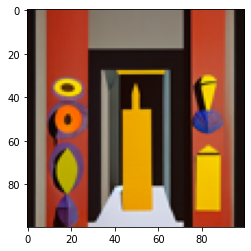

In [203]:
plt.imshow(img_list[0])

In [204]:
full_img.shape

(900, 1600, 3)

In [217]:
int_img = (full_img * 255).astype(np.uint8)

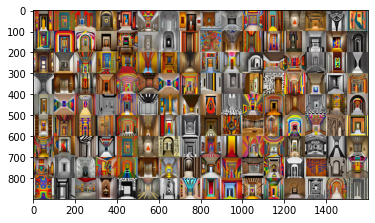

In [218]:
plt.imshow(int_img)

In [220]:
Image.fromarray(int_img).save('../results/output_museum_grid.png')

In [ ]:
1600 x 800

In [152]:
1600 / 40, 800 / 20

(40.0, 40.0)

In [151]:
40 * 20

800

In [135]:
32 * 18

576

In [138]:
(1600 * 900 / 1000) ** (1/2)

37.94733192202055